In [2]:
import json 

# path to your JSONL file
path = "/Users/henry/CS230-Project/results/summary-udf-inputs-typed.jsonl"

samples = []
with open(path, "r") as f:
    for line in f:
        if line.strip():                     # skip blank lines
            sample = json.loads(line)        # parse one JSON object
            samples.append(sample)


In [3]:
import pandas as pd

# create pandas DataFrame
df = pd.DataFrame(samples)
# print(df.head())

## What is the distribution of frequencies of programs using types of calls?

In [4]:
import pandas as pd
from itertools import chain

# Count raw occurrences per program (repo + path)
program_usage = (
    df.groupby(['repo_name', 'path'])
      .agg({
          'pyspark_ops': lambda x: sum(len(lst) for lst in x),
          'udfs':        lambda x: sum(len(lst) for lst in x),
          'third_party_libs': lambda x: sum(len(lst) for lst in x)
      })
      .rename(columns={
          'pyspark_ops': 'pyspark_ops_calls',
          'udfs': 'udf_calls',
          'third_party_libs': 'third_party_calls'
      })
      .reset_index()
)

program_usage['program_name'] = program_usage['repo_name'] + '/' + program_usage['path']

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sns.histplot(program_usage['pyspark_ops_calls'], bins=range(0, program_usage['pyspark_ops_calls'].max()+2), ax=axes[0])
axes[0].set_title('PySpark Operation Calls per Program')
axes[0].set_xlabel('# of PySpark calls')
axes[0].set_ylabel('Programs')

sns.histplot(program_usage['udf_calls'], bins=range(0, program_usage['udf_calls'].max()+2), ax=axes[1])
axes[1].set_title('UDF Calls per Program')
axes[1].set_xlabel('# of UDF calls')

sns.histplot(program_usage['third_party_calls'], bins=range(0, program_usage['third_party_calls'].max()+2), ax=axes[2])
axes[2].set_title('Third-Party Library Calls per Program')
axes[2].set_xlabel('# of library calls')

plt.tight_layout()
plt.show()

KeyError: 'path'

In [ ]:
import pandas as pd
from itertools import chain

# group by program (repo + path)
programs = (
    df.groupby(['repo_name', 'path'])
      .agg({
          'pyspark_ops': lambda x: sorted(set(chain.from_iterable(x))),
          'udfs':        lambda x: sorted(set(chain.from_iterable(x))),
          'third_party_libs': lambda x: sorted(set(chain.from_iterable(x)))
      })
      .reset_index()
)

# derive flags and counts
programs['pyspark_ops_count'] = programs['pyspark_ops'].apply(len)
programs['udf_count'] = programs['udfs'].apply(len)
programs['third_party_count'] = programs['third_party_libs'].apply(len)
programs['program_name'] = programs['repo_name'] + '/' + programs['path']


## Diving into UDF usage

In [ ]:
import pandas as pd
from collections import Counter

# df already loaded

rows = []

for _, row in df.iterrows():
    udfs = row.get("udfs", {})
    if not isinstance(udfs, dict):
        continue

    for udf_name, udf_meta in udfs.items():
        deps = udf_meta.get("third_party_dependencies", [])
        if not deps:
            continue

        for dep in deps:
            rows.append({
                "udf_name": udf_name,
                "third_party_dependencies": dep
            })

deps_df = pd.DataFrame(rows)

# counts per (udf, dependency)
udf_dep_counts = (
    deps_df
    .value_counts(["udf_name", "third_party_dependencies"])
    .reset_index(name="count")
)

# optional: total counts per dependency across all udfs
dep_totals = (
    deps_df
    .value_counts("third_party_dependencies")
    .reset_index(name="count")
    .rename(columns={"third_party_dependencies": "dependency"})
)

udf_dep_counts  # main result
# dep_totals    # if you want global popularity

,udf_name,third_party_dependencies,count
0,damerau_levenshtein_distance,jellyfish,1
1,hamming_distance,jellyfish,1
2,html_unescape,html,1
3,jaro_similarity,jellyfish,1
4,jaro_winkler_similarity,jellyfish,1
5,match_rating_codex,jellyfish,1
6,match_rating_comparison,jellyfish,1
7,metaphone,jellyfish,1
8,nysiis,jellyfish,1
9,porter_stem,jellyfish,1


/var/folders/0b/9qm_3x6j3js13zvns_g2m5dc0000gn/T/ipykernel_75921/38321334.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


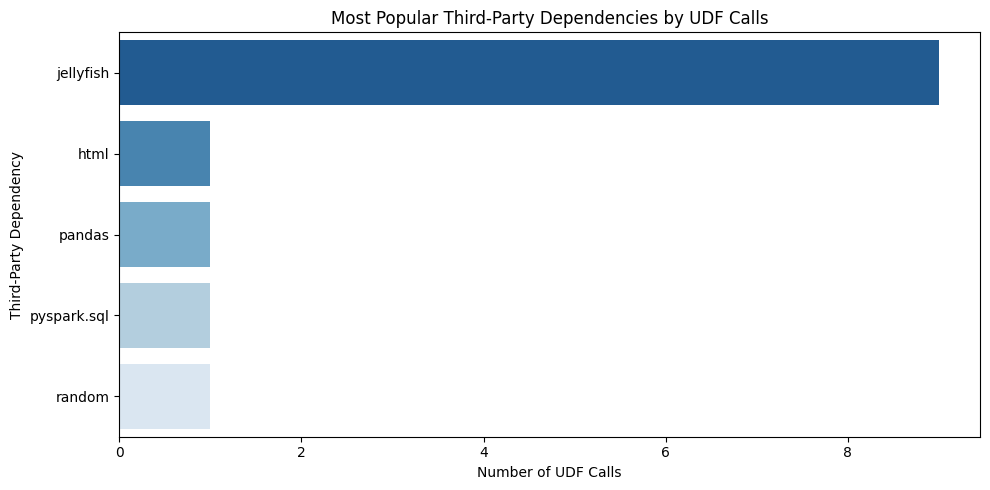

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# assume dep_totals from previous code
# (columns: dependency, count)

# sort and pick top N (e.g. 15)
top_n = dep_totals.sort_values("count", ascending=False).head(15)

plt.figure(figsize=(10,5))
sns.barplot(
    data=top_n,
    x="count",
    y="dependency",
    palette="Blues_r"
)
plt.title("Most Popular Third-Party Dependencies by UDF Calls")
plt.xlabel("Number of UDF Calls")
plt.ylabel("Third-Party Dependency")
plt.tight_layout()
plt.show()

        type_sig  count
0     StringType     60
1     DoubleType     34
2    IntegerType     30
3      ArrayType     14
4      FloatType     13
5     StructType      4
6    BooleanType      2
7  TimestampType      2
8       DateType      1
9       LongType      1


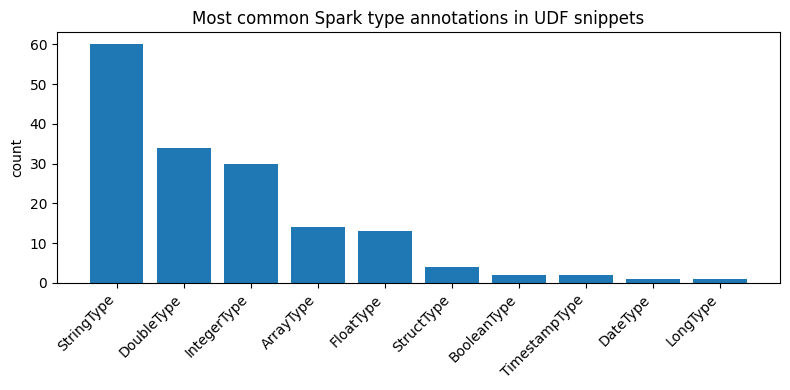

In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt

# 1) regex to find Spark types
TYPE_PATTERN = re.compile(r"\b(StringType|IntegerType|LongType|DoubleType|FloatType|BooleanType|TimestampType|DateType|ArrayType|MapType|StructType)\s*\(")

type_rows = []

for _, row in df.iterrows():
    snippet = row.get("snippet") or ""
    udfs = row.get("udfs") or {}
    if not isinstance(udfs, dict):
        continue

    # find all type mentions in this snippet
    types_found = TYPE_PATTERN.findall(snippet)
    if not types_found:
        continue

    # emit one row per udf per type
    for udf_name in udfs.keys():
        for t in types_found:
            type_rows.append({
                "udf_name": udf_name,
                "type_sig": t
            })

types_df = pd.DataFrame(type_rows)

# 2) aggregate: how many times each type shows up across UDFs
type_counts = (
    types_df
    .value_counts(["type_sig"])
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)

print(type_counts.head(20))

top_n = 15
plot_df = type_counts.head(top_n)

plt.figure(figsize=(8, 4))
plt.bar(plot_df["type_sig"], plot_df["count"])
plt.xticks(rotation=45, ha="right")
plt.title("Most common Spark type annotations in UDF snippets")
plt.ylabel("count")
plt.tight_layout()
plt.show()

